# Time Series using Deep learning RNN

## The Data


**Monthly milk production: pounds per cow. Jan 82 - Dec 95**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

** Read the dataset and set on Month column **

In [2]:
milk = pd.read_csv('monthly-milk-production.csv',index_col='Month')

** Check out the head of the dataframe**

In [3]:
milk.head()

,Milk Production
Month,
01-01-1982 01:00,589
01-02-1982 01:00,561
01-03-1982 01:00,640
01-04-1982 01:00,656
01-05-1982 01:00,727


** Plot out the time series data. **

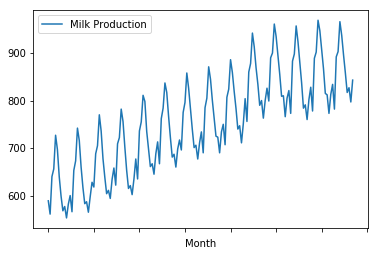

In [4]:
milk.plot()

# To Check Stationarity of the data

# 1.Rolling Statistics Method:

In [5]:
rolmean=milk.rolling(window=12).mean()
rolstd=milk.rolling(window=12).std()
print(rolmean,rolstd)


                  Milk Production
Month                            
01-01-1982 01:00              NaN
01-02-1982 01:00              NaN
01-03-1982 01:00              NaN
01-04-1982 01:00              NaN
01-05-1982 01:00              NaN
01-06-1982 01:00              NaN
01-07-1982 01:00              NaN
01-08-1982 01:00              NaN
01-09-1982 01:00              NaN
01-10-1982 01:00              NaN
01-11-1982 01:00              NaN
01-12-1982 01:00       615.750000
01-01-1983 01:00       616.666667
01-02-1983 01:00       617.083333
01-03-1983 01:00       618.166667
01-04-1983 01:00       619.583333
01-05-1983 01:00       620.833333
01-06-1983 01:00       622.416667
01-07-1983 01:00       624.083333
01-08-1983 01:00       625.583333
01-09-1983 01:00       626.833333
01-10-1983 01:00       627.666667
01-11-1983 01:00       628.666667
01-12-1983 01:00       630.000000
01-01-1984 01:00       632.333333
01-02-1984 01:00       636.666667
01-03-1984 01:00       639.583333
01-04-1984 01:

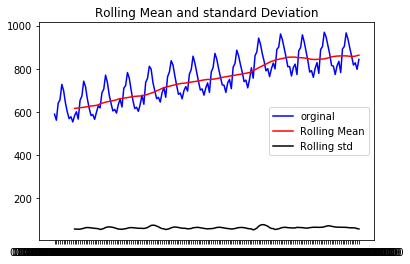

In [6]:
orig=plt.plot(milk,color='blue',label='orginal')
#org=milk.plot()
mean=plt.plot(rolmean,color='red',label='Rolling Mean')
std=plt.plot(rolstd,color='black',label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean and standard Deviation')
plt.show(block=False)
             

# 2.ADCF(Dicky Fuller test)

In [7]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dicky Fuller test')
dftest=adfuller(milk['Milk Production'],autolag='AIC')

dfoutput=pd.Series(dftest[0:4] ,index=['test Statistic','pvalue','#Lags used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critica value (%s)'%key] =value

print(dfoutput)   


Results of Dicky Fuller test
test Statistic                  -1.303812
pvalue                           0.627427
#Lags used                      13.000000
Number of Observations Used    154.000000
Critica value (1%)              -3.473543
Critica value (5%)              -2.880498
Critica value (10%)             -2.576878
dtype: float64


#### PVALUE is at higher end and we cannot reject null hypothises and the data is Time Dependent

### Train Test Split

** Let's attempt to predict a year's(1995) worth of data. (12 months or 12 steps into the future) **


In [8]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 01-01-1982 01:00 to 01-12-1995 01:00
Data columns (total 1 columns):
Milk Production    168 non-null int64
dtypes: int64(1)
memory usage: 2.6+ KB


In [9]:
train_set = milk.head(156)

In [10]:
test_set = milk.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler.

In [11]:
from sklearn.preprocessing import MinMaxScaler


In [12]:
scaler = MinMaxScaler()

In [13]:
train_scaled = scaler.fit_transform(train_set)

C:\Users\raprabhu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [14]:
test_scaled = scaler.transform(test_set)

In [15]:
test_scaled

array([[0.67548077],
       [0.55048077],
       [0.81490385],
       [0.84134615],
       [0.99278846],
       [0.92307692],
       [0.82451923],
       [0.73317308],
       [0.63461538],
       [0.65865385],
       [0.58653846],
       [0.69711538]])

## Batch Function

** We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! **

In [16]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Setting Up The RNN Model

** Import TensorFlow **

In [17]:
import tensorflow as tf

### The Constants

** Define the constants in a single cell.**
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.003)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [18]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.001 
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 4000
# Size of the batch of data
batch_size = 1

In [19]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [34]:
# Define GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [21]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [22]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [23]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [24]:
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. **

In [25]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [26]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.15872048
100 	MSE: 0.05607578
200 	MSE: 0.035299968
300 	MSE: 0.02368849
400 	MSE: 0.025866529
500 	MSE: 0.010668305
600 	MSE: 0.018470654
700 	MSE: 0.008502097
800 	MSE: 0.0064963712
900 	MSE: 0.0052793887
1000 	MSE: 0.0042691547
1100 	MSE: 0.0055771363
1200 	MSE: 0.0062443153
1300 	MSE: 0.0069636554
1400 	MSE: 0.0059301504
1500 	MSE: 0.0064280774
1600 	MSE: 0.0089863185
1700 	MSE: 0.00926358
1800 	MSE: 0.005591788
1900 	MSE: 0.0063230763
2000 	MSE: 0.006606754
2100 	MSE: 0.0055753146
2200 	MSE: 0.0041228137
2300 	MSE: 0.0053667785
2400 	MSE: 0.00633584
2500 	MSE: 0.0093650585
2600 	MSE: 0.00404684
2700 	MSE: 0.003363572
2800 	MSE: 0.005885226
2900 	MSE: 0.00318507
3000 	MSE: 0.005489418
3100 	MSE: 0.003153403
3200 	MSE: 0.0038706248
3300 	MSE: 0.003899663
3400 	MSE: 0.009452819
3500 	MSE: 0.00200449
3600 	MSE: 0.0034227034
3700 	MSE: 0.0049741715
3800 	MSE: 0.0046458743
3900 	MSE: 0.0038634099


______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [27]:
test_set

,Milk Production
Month,
01-01-1995 01:00,834
01-02-1995 01:00,782
01-03-1995 01:00,892
01-04-1995 01:00,903
01-05-1995 01:00,966
01-06-1995 01:00,937
01-07-1995 01:00,896
01-08-1995 01:00,858
01-09-1995 01:00,817


** Now we want to attempt to predict these 12 months of data, using only the training data set model. 

** Fill out the session code below to generate 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes.**

In [28]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-12:])
    
    ## Now create a for loop that 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ex_time_series_model


** Show the result of the predictions. **

In [29]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.6190313,
 0.6391243,
 0.7206217,
 0.88328713,
 1.019077,
 1.0466787,
 0.96030366,
 0.81581384,
 0.71755797,
 0.62301445,
 0.60193187,
 0.6076815]

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [30]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

** Create a new column on the test_set data called "Generated".

In [31]:
test_set['Generated'] = results

C:\Users\raprabhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** View the test_set dataframe. **

In [32]:
test_set

,Milk Production,Generated
Month,,
01-01-1995 01:00,834,810.517029
01-02-1995 01:00,782,818.875671
01-03-1995 01:00,892,852.778687
01-04-1995 01:00,903,920.447449
01-05-1995 01:00,966,976.936035
01-06-1995 01:00,937,988.418335
01-07-1995 01:00,896,952.486328
01-08-1995 01:00,858,892.378540
01-09-1995 01:00,817,851.504089


** Plot out the two columns for comparison. **

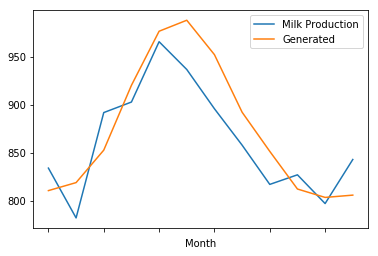

In [33]:
test_set.plot()